# Статистический анализ данных

Мне, как аналитику популярного сервиса аренды самокатов GoFast, передали данные о некоторых пользователях из нескольких городов, а также об их поездках и вариантах подписки. Для совершения поездок, пользователи сервиса используют мобильное приложение. Арендовать самокат можно либо с подпиской Ultra, либо без подписки. Для каждого варианта установлены свои тарифы.

**Цель исследования:**

Необходимо проанализировать данные и проверить несколько гипотез, которые могут помочь бизнесу вырасти

**Ход исследования**:

* [загрузка данных;](### Загрузка данных)
* предобработка данных;
* поиск и исправление аномалий;
* добавление столбцов и объединение датафреймов;
* исследовательский анализ данных;
* создание датафрейма со сборными данными по поездкам и выручкой;
* проверка гипотез по увеличению количества пользователей с подпиской;
* визуализация распределений.

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

import pymorphy2

import warnings
warnings.simplefilter("ignore")

### Загрузка данных

Прочитаем данные в исходных датасетах:

In [2]:
users, rides, subscriptions = (
    pd.read_csv('users_go.csv'),                       # пользователи
    pd.read_csv('rides_go.csv', parse_dates=['date']), # поездки
    pd.read_csv('subscriptions_go.csv')                # подписки
)

Состав первого датафрейма:

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


У нас 5 столбцов, которые полностью чем-то заполнены)), два целочисленных, остальные текстовые.

А что внутри?

In [4]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


Выглядят очень аккуратненько, никакого мусора)

Второй датафрейм:

In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


И здесь полный порядок, только формат столбца date поменять.

In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


Пока не к чему придраться)

Третий датафрейм:

In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


И здесь полный порядок.

### Предобработка данных

Прежде всего, выведем сводку статистических данных для всех столбцов датафрейма users, включая как числовые так и категориальные:

In [9]:
users.describe(include='all')

,user_id,name,age,city,subscription_type
count,1565.000000,1565,1565.000000,1565,1565
unique,NaN,194,NaN,8,2
top,NaN,Мария,NaN,Пятигорск,free
freq,NaN,23,NaN,226,846
mean,762.633866,NaN,24.922045,NaN,NaN
std,443.260155,NaN,4.553496,NaN,NaN
min,1.000000,NaN,12.000000,NaN,NaN
25%,378.000000,NaN,22.000000,NaN,NaN
50%,762.000000,NaN,25.000000,NaN,NaN
75%,1146.000000,NaN,28.000000,NaN,NaN


Если взять данные как есть, пока ничего не уточняя, то уже можно вывести некий наиболее вероятный портрет пользователя сервиса аренды самокатов GoFast. Это Мария из Пятигорска, возрастом примерно 25 лет, с бесплатной подпиской. Интересно, существует ли реально такой пользователь))?

Что еще интересно в этой сводке? Число городов - 8 и нужно их проверить на неявные дубликаты. Возраст пользователей от 12 до 43 лет. Идентификационный номер пользователей начинается с единицы и заканчивается числом 1534. Но если мы посмотрим на общее число user_id (=1565), то поймем, что у нас есть как минимум 31 строка с каким-то нарушением в столбце user_id.

Проверим столбец с городами на неявные дубликаты:

In [10]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

С городами порядок, 8 штук. Теперь посмотрим, нет ли у нас полных дубликатов строк:

In [11]:
users.duplicated().sum()

31

Действительно, у нас 31 полный дубликат. Исправим это недоразумение:

In [12]:
users = users.drop_duplicates(keep='first')

Построим также гистограммы для числовых значений:

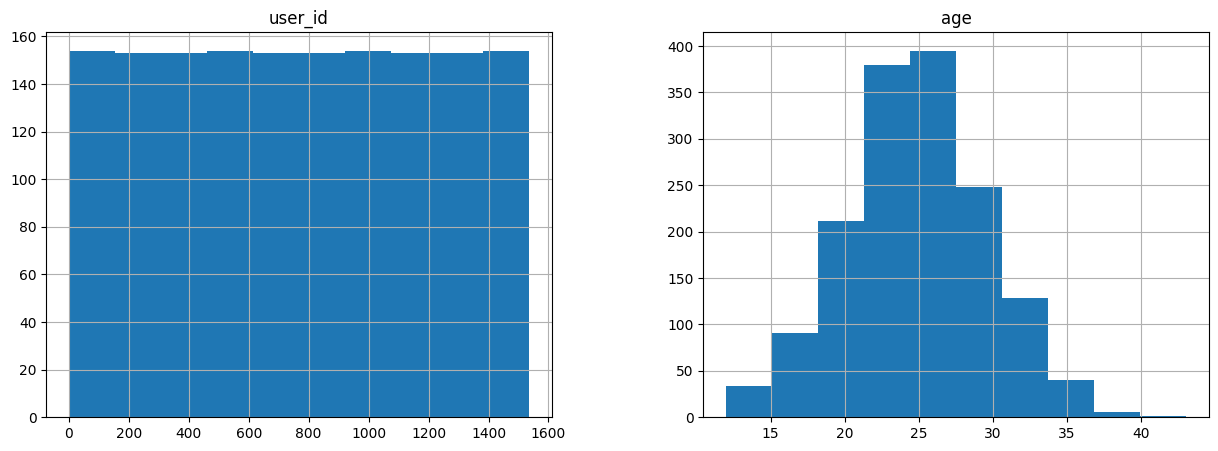

In [13]:
users.hist(figsize=(15, 5));

Аномалий не видно. С предобработкой датафрейма users мы справились. Хотя... У нас есть столбец с именами, вроде бы совсем бесполезный, из которого сложно непосредственно получить какие-то значимые выводы. Зато,  зная имя пользователя, мы можем определить его пол. А это уже вполне полезная и интересная задача. Для опеределения пола по имени можно использовать морфологический анализатор pymorphy2, который способен определить род по грамматическим признакам:

In [14]:
# Инициализация MorphAnalyzer
morph = pymorphy2.MorphAnalyzer()

def get_gender(name):
    parsed = morph.parse(name)[0]
    if 'masc' in parsed.tag:
        return 'Мужской'
    elif 'femn' in parsed.tag:
        return 'Женский'
    else:
        return 'Неизвестно'

users['gender'] = users['name'].apply(get_gender)

In [15]:
users.head()

,user_id,name,age,city,subscription_type,gender
0,1,Кира,22,Тюмень,ultra,Женский
1,2,Станислав,31,Омск,ultra,Мужской
2,3,Алексей,20,Москва,ultra,Мужской
3,4,Константин,26,Ростов-на-Дону,ultra,Мужской
4,5,Адель,28,Омск,ultra,Женский


Вроде работает. Проверим, всем ли именам удалось определить род:

In [16]:
users.query('gender=="Неизвестно"')

,user_id,name,age,city,subscription_type,gender
38,39,Майя,23,Омск,ultra,Неизвестно
150,151,Майя,26,Омск,ultra,Неизвестно
346,347,Злата,24,Москва,ultra,Неизвестно
446,447,Майя,19,Москва,ultra,Неизвестно
468,469,Майя,24,Сочи,ultra,Неизвестно
551,552,Майя,32,Омск,ultra,Неизвестно
570,571,Майя,23,Краснодар,ultra,Неизвестно
658,659,Злата,27,Ростов-на-Дону,ultra,Неизвестно
694,695,Злата,14,Тюмень,ultra,Неизвестно
946,947,Злата,23,Ростов-на-Дону,free,Неизвестно


Для двух женских имен не удалось это сделать. Исправим:

In [17]:
users.loc[(users['name'] == 'Майя') | (users['name'] == 'Злата'), 'gender'] = 'Женский'

Возьмем следующий датафрейм rides и изучим данные в нем похожим образом. Но сначала  создадим на основе столбца date новый столбец с номером месяца.

In [18]:
rides['month'] = rides['date'].dt.month

Смотрим статистику:

In [19]:
rides.describe(include='all', datetime_is_numeric=True)

,user_id,distance,duration,date,month
count,18068.000000,18068.000000,18068.000000,18068,18068.000000
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296,6.486772
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00,1.000000
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00,4.000000
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00,6.000000
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00,9.000000
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00,12.000000
std,434.734317,1116.831209,6.091051,NaN,3.437410


Пока ничего криминального не видно. Все поездки происходили в течение одного года - 2021-го. Среднее расстояние поездки - 3 километра, средняя продолжительность - около 18 минут. Максимальные расстояние и продолжительность выглядят правдоподобно, а вот минимальные - есть вопросы. Например, расстояние 85 сантиметров. Что-то видимо таким пользователям помешало продолжить движение.

Посмотрим на гистограммы. Добавим число корзин для более детального взгляда:

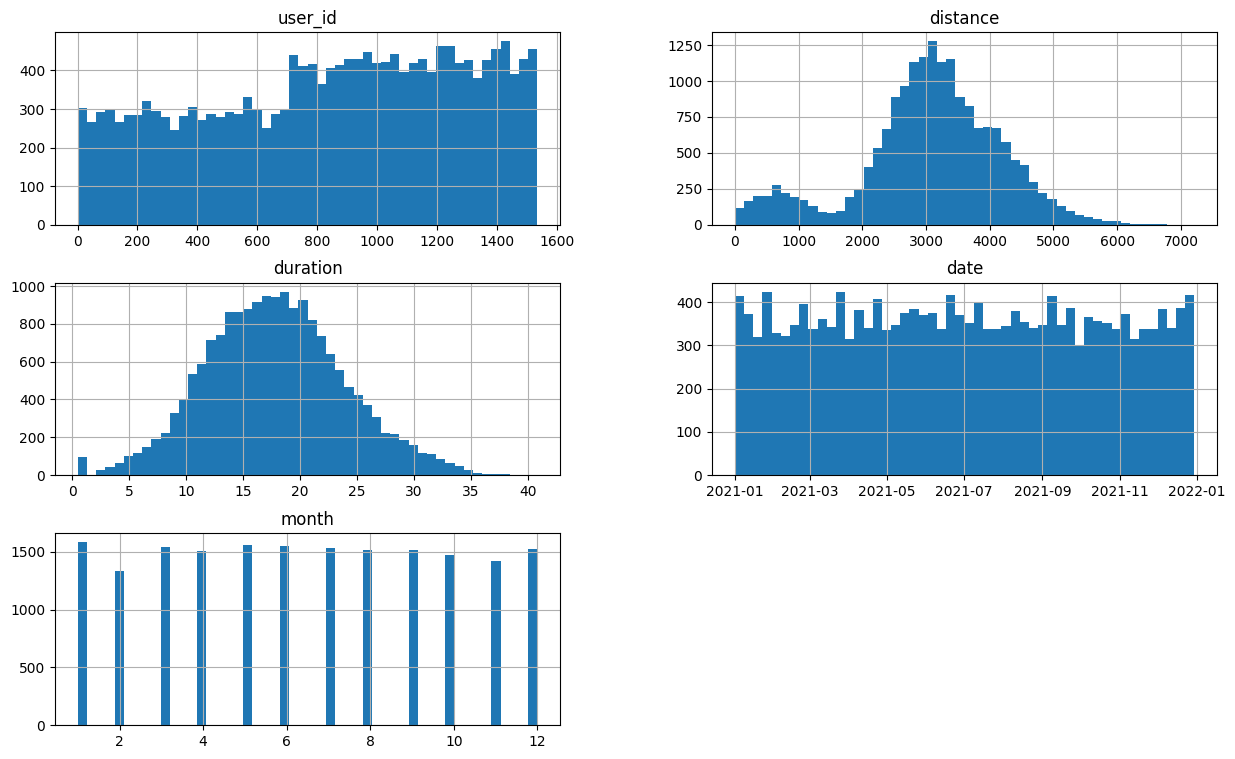

In [20]:
rides.hist(bins=50, figsize=(15, 9));

Среди полученных гистограмм повышенный интерес с точки зрения аномалий вызывают две - user_id и duration. На первой гистограмме мы наблюдаем резкий скачок количества поездок, примерно на 30%, для пользователей с номером идентификатора в районе 700 и выше. На гистограмме столбца duration есть аномальный пичок рядом с нулем. 

Гистограммы по столбцам date и month тоже выглядят подозрительно ровными, никакой сезонности. Как объяснить сравнимое число поездок в январе и июле в нашей северной стране? Вероятнее всего, здесь мы имеем дело со стратифицированной по месяцам выборкой. Для каждого месяца были взяты случайные выборки, примерно равные по размеру. На будущее, возможно, имеет смысл рекомендовать делать случайную выборку для каждого месяца пропорционально его доле в генеральной совокупности, чтобы проявился фактор сезонности. В первую очередь, это позволит точнее прогнозировать изменение выручки в течение года.

Небольшое отступление. Вообще говоря, среди представленных городов, пожалуй только Сочи может претендовать на круглогодичную работу кикшеринга. В остальных городах зимой температура в большей или меньшей степени бывает отрицательной, в связи с чем сервис аренды работает 9 месяцев в году, исключая зимние. Т.е. реальное число поездок зимой и летом должно отличаться в разы, если не в десятки раз.

Гистограмма по distance выглядит немного необычно, как бы соединив две независимые гистограммы на одном графике. Можно будет дальше посмотреть в чем дело - возможно удастся выявить отдельные группы пользователей для двух случаев.

Посмотрим на частоту значений в столбце duration:

In [21]:
rides['duration'].value_counts()

0.500000     95
22.184080     1
25.866000     1
22.837062     1
19.173800     1
             ..
18.843765     1
17.644888     1
22.477965     1
19.745218     1
16.537044     1
Name: duration, Length: 17974, dtype: int64

Вот и наш пичок. Подозрительные круглые полминуты повторяются 95 раз. Отберем только эти строки и изучим остальные столбцы для таких строк:

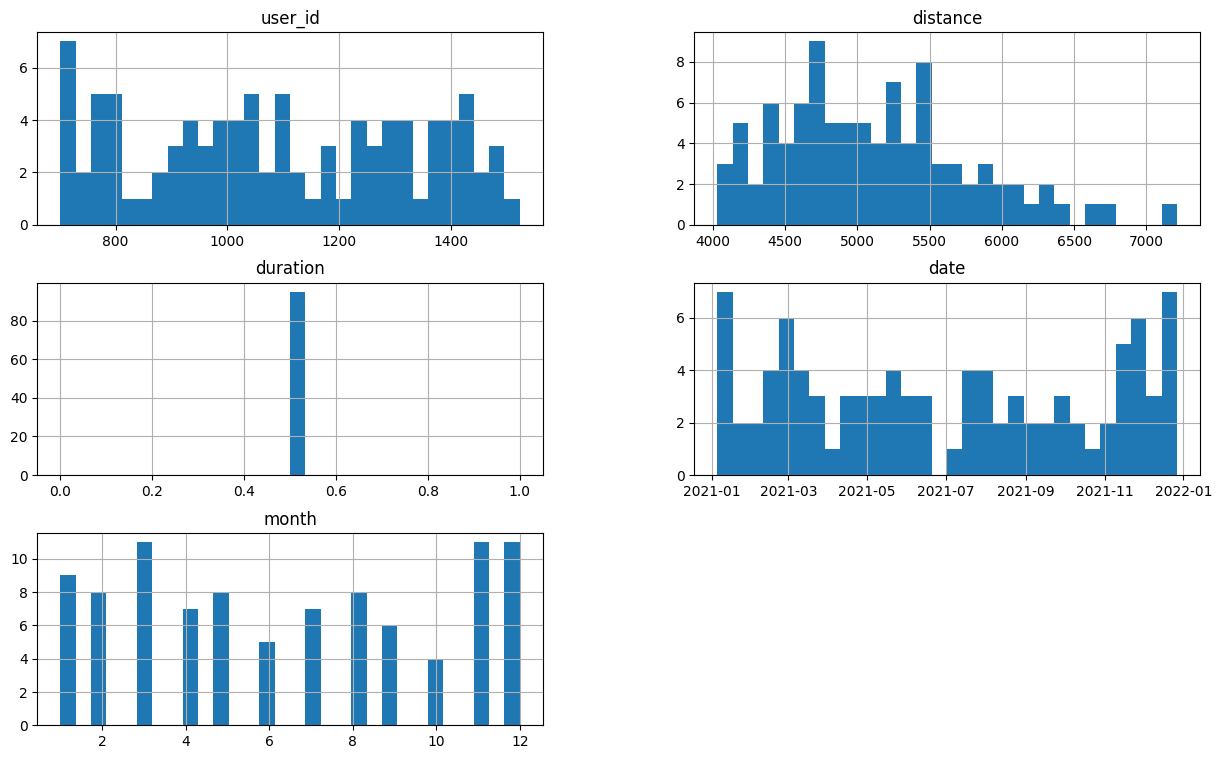

In [22]:
rides.query('duration==0.5').hist(bins=30, figsize=(15, 9));

Гистограмма столбца distance начинается после 4 километров. Это многовато для продолжительности сессии в 30 секунд, т.е. в паре время-дистанция одно из значений указано неверно. Мы не сильно ошибемся, если предположим, что это время. Здесь возможны два решения этой ситуации. Самое простое - удалить эти строки. Они составляют примерно 0,5% от общего числа.

Другой вариант - попробовать восстановить нормальную продолжительность поездки. Для этого можно воспользоваться данными о расстоянии.

Давайте в этом месте объединим три наших датафрейма, чтобы увеличить число связанных данных, что может помочь найти ответы на вопросы:

In [23]:
df_1 = pd.merge(users, rides, on='user_id', how='outer')

In [24]:
df = pd.merge(df_1, subscriptions, on='subscription_type', how='left')

Теперь сделаем срез по строкам с ошибочным временем и построим гистограммы:

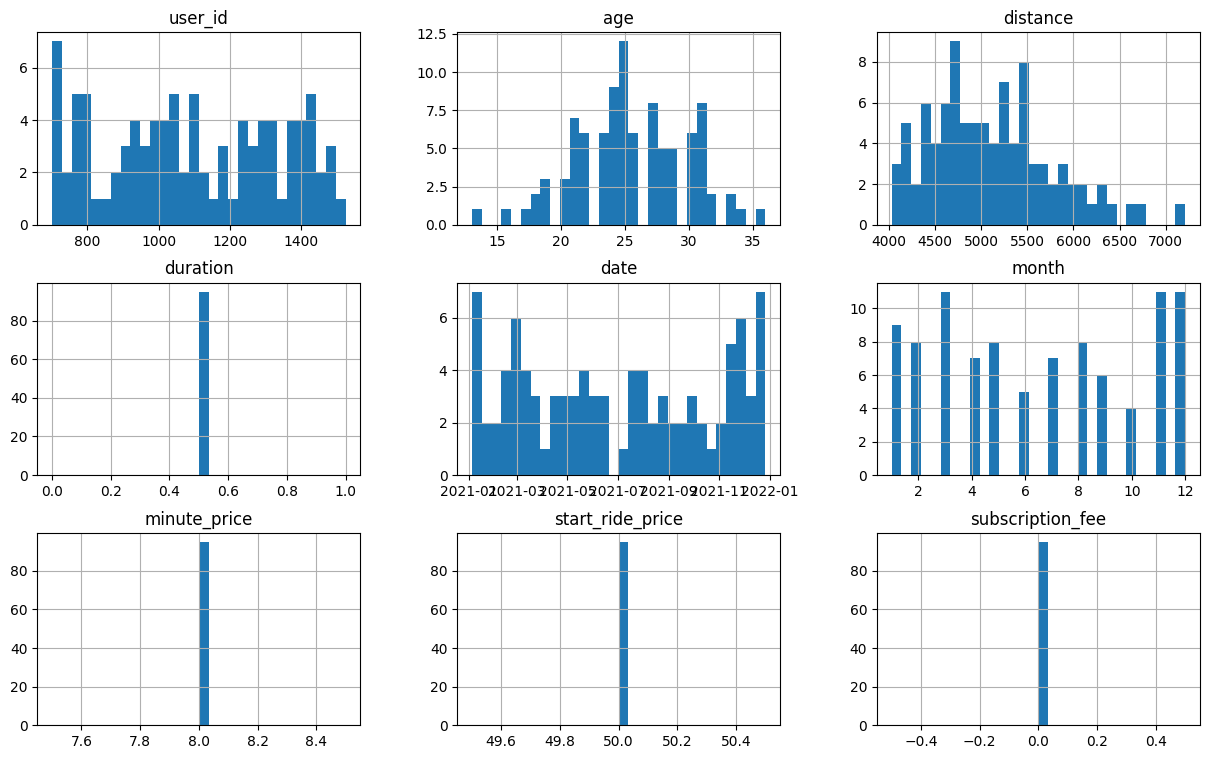

In [25]:
df.query('duration==0.5').hist(bins=30, figsize=(15, 9));

Во-первых, мы видим, что нижние три гистограммы указывают только на один тип подписки - бесплатный. И, второе, гистограмма по столбцу user_id начинается не с нуля, а где-то в районе 700 номера. С этим номером мы уже сталкивались - где-то там происходит скачок количества поездок. Теперь у нас есть зацепка, проверим по виду подписки номера. Сделаем срез по бесплатным подписчикам и отсортируем в порядке возрастания идентификаторов пользователей:

In [26]:
df.query('subscription_type=="free"').sort_values(by='user_id').head()

,user_id,name,age,city,subscription_type,gender,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,Мужской,2515.690719,14.944286,2021-01-02,1,8,50,0
6517,700,Айдар,22,Омск,free,Мужской,3686.409695,13.899449,2021-11-21,11,8,50,0
6516,700,Айдар,22,Омск,free,Мужской,2639.817512,8.656752,2021-11-14,11,8,50,0
6515,700,Айдар,22,Омск,free,Мужской,2409.555418,8.560513,2021-11-03,11,8,50,0
6514,700,Айдар,22,Омск,free,Мужской,4402.389717,33.013035,2021-10-15,10,8,50,0


Отлично! Мы получили, что минимальный id пользователя с бесплатной подпиской равен 700. Но вдруг платные подписчики где-то могли затесаться со своим id между 700 и 1534? Проверим это:

In [27]:
df.query('subscription_type=="ultra"').sort_values(by='user_id').tail()

,user_id,name,age,city,subscription_type,gender,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6498,699,Оксана,22,Москва,ultra,Женский,4707.845501,15.839579,2021-10-17,10,6,0,199
6493,699,Оксана,22,Москва,ultra,Женский,4072.797406,16.575991,2021-06-02,6,6,0,199
6492,699,Оксана,22,Москва,ultra,Женский,3433.522627,19.734091,2021-03-29,3,6,0,199
6494,699,Оксана,22,Москва,ultra,Женский,3045.277646,19.610605,2021-08-25,8,6,0,199
6499,699,Оксана,22,Москва,ultra,Женский,3202.890770,25.217345,2021-12-03,12,6,0,199


Нет. Платные подписчики заканчиваются номером 699.

Так мы попутно выяснили причину скачка. Оказывается, бесплатные подписчики, номера которых 700 и выше, гораздо активнее пользуются сервисом проката, чем платные.

Теперь вернемся к исходному вопросу - что делать с неправильным временем в столбце duration. Мы установили, что это касается только бесплатных подписчиков сервиса. Попробуем для них построить диаграмму рассеяния, где каждая точка будет отображать пройденное расстояние в зависимости от времени:

In [28]:
df_free = df.query('subscription_type=="free"')

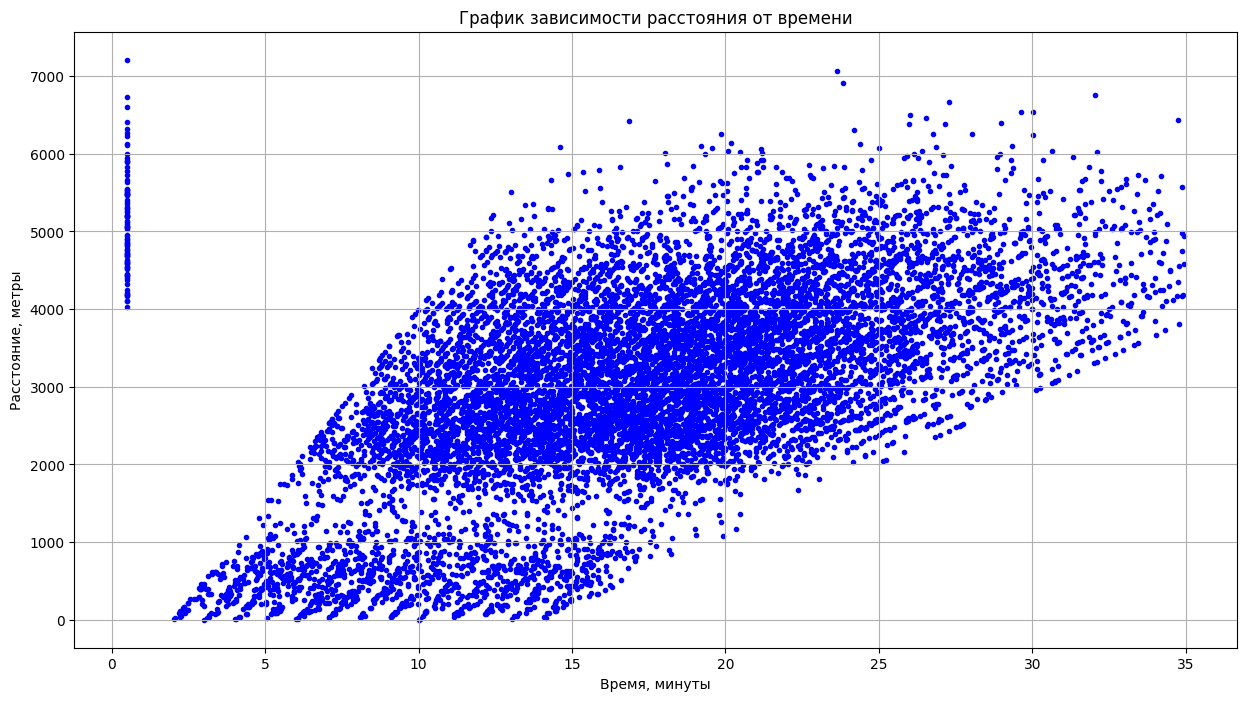

In [29]:
plt.figure(figsize=(15, 8))
plt.scatter(df_free['duration'], df_free['distance'], marker='.', color='b')

plt.title('График зависимости расстояния от времени')
plt.xlabel('Время, минуты')
plt.ylabel('Расстояние, метры')
plt.grid(True)

plt.show()

Да, по такому графику сложно выставить правильное время. Но зато можно сделать некоторые общие выводы:
* минимальное время сеанса - 2 минуты, максимальное - 35 минут;
* для того, чтобы начать движение, пользователю может потребоваться от 2 до 14 минут;
* веер точек имеет четкие границы слева и справа, по которым можно определить соответственно максимальную и минимальную скорость движения, например, начав движение на 2-й минуте, пользователь мог к 10-й минуте преодолеть 4 км (за 8 минут), умножаем на 7,5 - получаем максимальную скорость 30 км/ч, то же самое для минимальной - получим 10 км/ч;
* самые короткие поездки имеют необъяснимую привязку по длительности к целому числу минут.

Давайте разберемся с привязкой к целому числу минут. Посмотрим на короткие поездки - ограничим дистанцию, скажем, до 100 метров:

In [30]:
df_free_100m = df_free.query('distance<100')

И таких поездок всего:

In [31]:
len(df_free_100m)

78

Посмотрим на столбец duration в этом датафрейме:

In [32]:
df_free_100m['duration']

6611     14.143966
6691      2.053251
6816      7.178766
6850      3.166221
7367      8.164172
           ...    
17414     6.074381
17502     9.237560
17646     4.170782
17722     3.218576
17760     5.174400
Name: duration, Length: 78, dtype: float64

Действительно, значения времен находятся рядом с целым числом минут, причем подозрительно располагаются только сверху целого числа. Учитывая, что при поминутной оплате идет округление до целой минуты в большую сторону, такая "однобокость" бросает тень на владельцев сервиса. Проверим, сколько есть значений при поездке до 100 м, у которых для duration первое число после десятичной точки 5 и больше:

In [33]:
# Извлечение дробной части и проверка условия
condition = df_free_100m['duration'].astype(str).str.split('.').str[1].str[0].isin(['5', '6', '7', '8', '9'])

# Подсчет количества значений, которые соответствуют условию
count = condition.sum()

# Вычисление процента
percentage = (count / len(df_free_100m)) * 100

percentage

0.0

А если посмотреть на весь датафрейм?

In [34]:
# Извлечение дробной части и проверка условия
condition = df['duration'].astype(str).str.split('.').str[1].str[0].isin(['5', '6', '7', '8', '9'])

# Подсчет количества значений, которые соответствуют условию
count = condition.sum()

# Вычисление процента
percentage = (count / len(df)) * 100

percentage

50.55899933584237

О! Даже перевалило за 50 %. Короче, понятно, что мы должны, вообще-то, получить число, близкое к 50%.

А так, получается, что у коротких поездок менее 100 метров, какая-то своя теория вероятности. Посчитаем вероятность произошедшего)). Вероятность встретить 5, 6, 7, 8 или 9 сразу после десятичной точки для первого значения времени равна $\frac{1}{2}$, вслед за ним для второго значения $\frac{1}{2}\cdot \frac{1}{2}$ и т.д. Для 78 значений подряд получим вероятность $2^{-78}$. Похоже, провидение на стороне владельцев сервиса))

А что у платных подписчиков?

In [35]:
df_ultra = df.query('subscription_type=="ultra"')

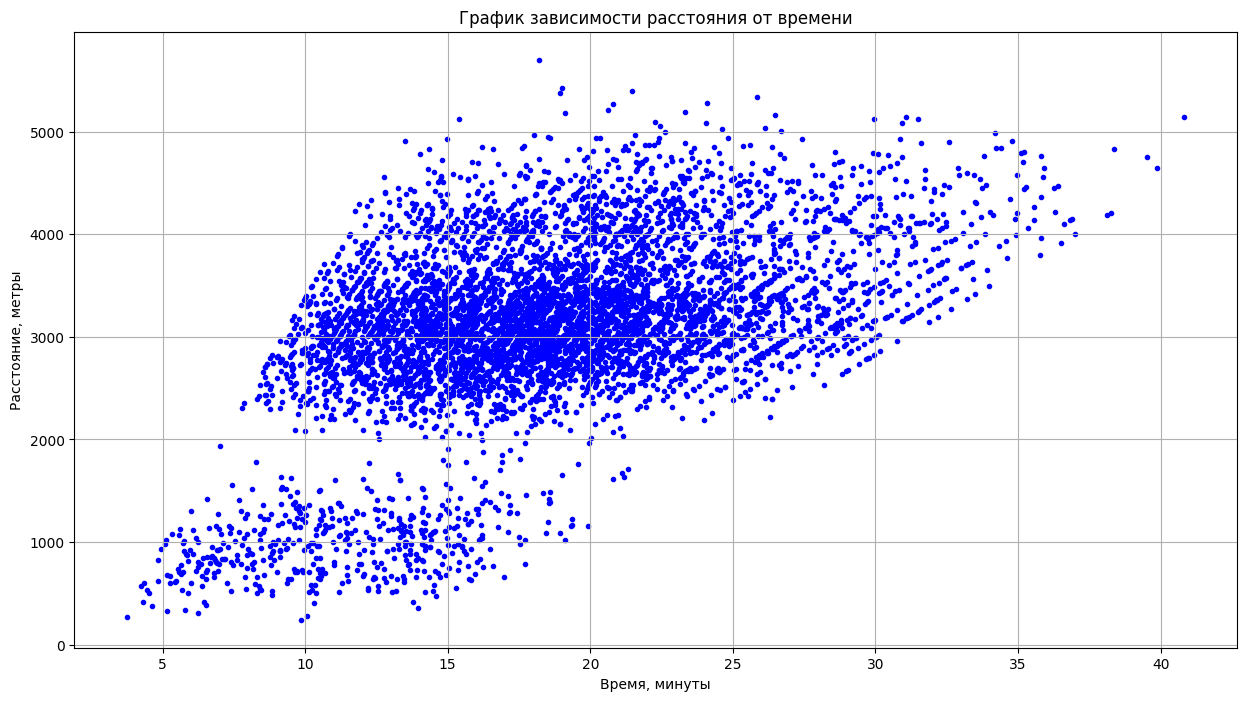

In [36]:
plt.figure(figsize=(15, 8))
plt.scatter(df_ultra['duration'], df_ultra['distance'], marker='.', color='b')

plt.title('График зависимости расстояния от времени')
plt.xlabel('Время, минуты')
plt.ylabel('Расстояние, метры')
plt.grid(True)

plt.show()

Похоже, у них такой привязки к минутам нет.

Да, мы границу в 100 метров взяли наобум. Посчитаем поточнее, где заканчивается провидение и начинают действовать обычные законы вселенной:

In [37]:
# Извлечение дробной части и проверка условия
condition = df_free['duration'].astype(str).str.split('.').str[1].str[0].isin(['5', '6', '7', '8', '9'])

# Фильтрация строк, которые удовлетворяют условию
df_filtered = df_free[condition]

# Определение минимального значения в столбце 'distance' для удовлетворяющих строк
df_filtered['distance'].min()

130.83928035230718

Итак, 130 метров. Столько нужно проехать, чтобы отключилась привязка к минутам, и вам не пришлось переплачивать за лишнюю минуту.

А мы едем дальше. Точнее, опять возвращаемся к полуминутным поездкам. Посмотрим на датафрейм таких поездок:

In [38]:
df_free.query('duration==0.5').head()

,user_id,name,age,city,subscription_type,gender,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6531,701,Иван,31,Екатеринбург,free,Мужской,4196.445201,0.5,2021-08-31,8,8,50,0
6570,704,Мирон,29,Ростов-на-Дону,free,Мужской,4830.824371,0.5,2021-10-14,10,8,50,0
6680,712,Дарья,28,Москва,free,Женский,4684.004397,0.5,2021-03-04,3,8,50,0
6695,713,Святослав,30,Краснодар,free,Мужской,5215.642710,0.5,2021-02-25,2,8,50,0
6768,718,Владислава,31,Москва,free,Мужской,5197.436649,0.5,2021-02-11,2,8,50,0


Не видно какой-то системы в данных. Возьмем любое id и посмотрим по нему полную информацию, отсортируем по расстоянию:

In [39]:
df_free[df_free['user_id']==704].sort_values(by='distance')

,user_id,name,age,city,subscription_type,gender,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6573,704,Мирон,29,Ростов-на-Дону,free,Мужской,273.668337,14.965888,2021-11-30,11,8,50,0
6563,704,Мирон,29,Ростов-на-Дону,free,Мужской,474.400151,4.016572,2021-06-27,6,8,50,0
6569,704,Мирон,29,Ростов-на-Дону,free,Мужской,2065.341081,8.130682,2021-09-08,9,8,50,0
6568,704,Мирон,29,Ростов-на-Дону,free,Мужской,2131.002178,10.566433,2021-08-18,8,8,50,0
6571,704,Мирон,29,Ростов-на-Дону,free,Мужской,2794.727978,14.898745,2021-11-02,11,8,50,0
6567,704,Мирон,29,Ростов-на-Дону,free,Мужской,3054.369333,24.453885,2021-07-24,7,8,50,0
6560,704,Мирон,29,Ростов-на-Дону,free,Мужской,3056.448107,21.641120,2021-05-30,5,8,50,0
6558,704,Мирон,29,Ростов-на-Дону,free,Мужской,3197.139639,17.719472,2021-01-31,1,8,50,0
6559,704,Мирон,29,Ростов-на-Дону,free,Мужской,3326.262342,10.983030,2021-04-29,4,8,50,0
6566,704,Мирон,29,Ростов-на-Дону,free,Мужской,3353.418345,22.291373,2021-07-05,7,8,50,0


Была надежда, что человек ездит примерно с одной средней скоростью и можно будет для конкретного пользователя исправить время, исходя из его средней скорости. Но нет.

Ок. Не будем сильно усложнять.Строки с неправильным duration в остальном вполне нормальные, поэтому сохраним их и просто посчитаем значения исходя из общей средней скорости. Выше мы примерно получили из графика диапазон скоростей от 10 до 30 км/ч, следовательно средняя - 20 км/ч. Один метр самокат преодолевает за 60/20000 = 0.003 минуты. Теперь можем исправить значения в столбце duration:

In [40]:
df.loc[df['duration']==0.5, 'duration'] = df['distance'] * 0.003

Естественно, приведем в соответствие и df_free

In [41]:
df_free = df.query('subscription_type=="free"')

Насчет необычной двойной гистограммы столбца distance - не удалось найти в данных какой-то зацепки, чтобы объяснить причину такого поведения пользователей. Данная аномалия не имеет привязки ни к одному из остальных параметров поездки.

### Исследовательский анализ данных

Посчитаем, в каких городах зарегистрировано больше пользователей. Логично при этом использовать датафрейм users :

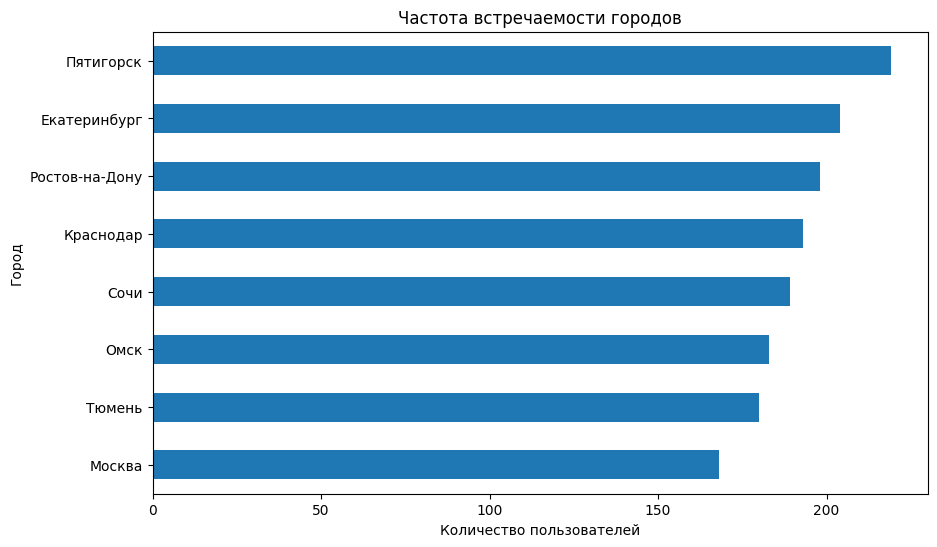

In [42]:
plt.figure(figsize=(10, 6))
users['city'].value_counts(ascending=True).plot(kind='barh')
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.show()

Число пользователей сервиса из Пятигорска, в котором проживает около 150 тыс. человек, превышает число пользователей из Москвы, жителей в которой примерно в 100 раз больше. И это не случайность - другие города миллионники тоже не дотягивают до уровня Пятигорска. Это вторая "странность" наших данных. Первая была про равное число поездок зимой и летом. Т.е. и здесь мы имеем дело со стратифицированной выборкой, состоящей из случайных выборок, уравновешенных по числу пользователей в городах.

Добавим таблицу со значениями частотности городов:

In [43]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

В Пятигорске зарегистрировано 219 пользователей сервиса, в Москве - 168. Остальные города занимают промежуточные значения.

Соотношение пользователей с подпиской и без в абсолютных цифрах:

In [44]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

В процентах графически:

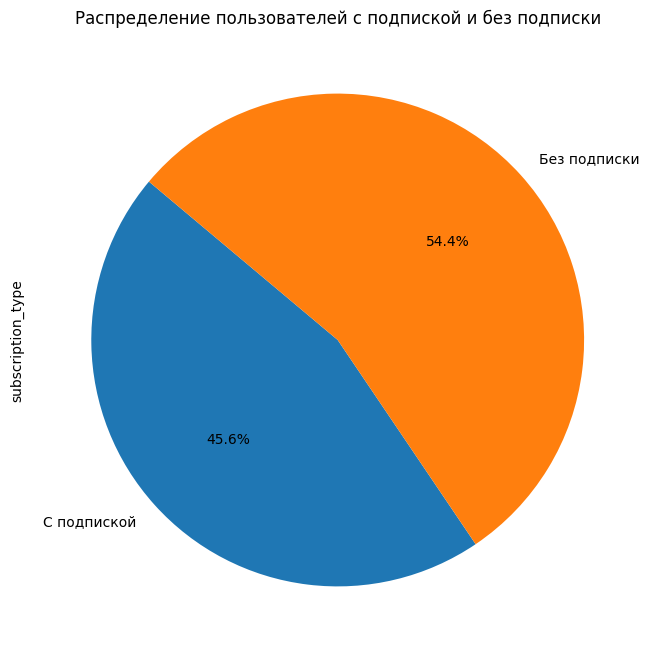

In [45]:
labels = ['С подпиской', 'Без подписки']

plt.figure(figsize=(8, 8))
users['subscription_type'].value_counts(ascending=True).plot(kind='pie', labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Распределение пользователей с подпиской и без подписки')
plt.show()

Без подписки пользователей несколько больше.

Посмотрим теперь на распределение пользователей по возрастам:

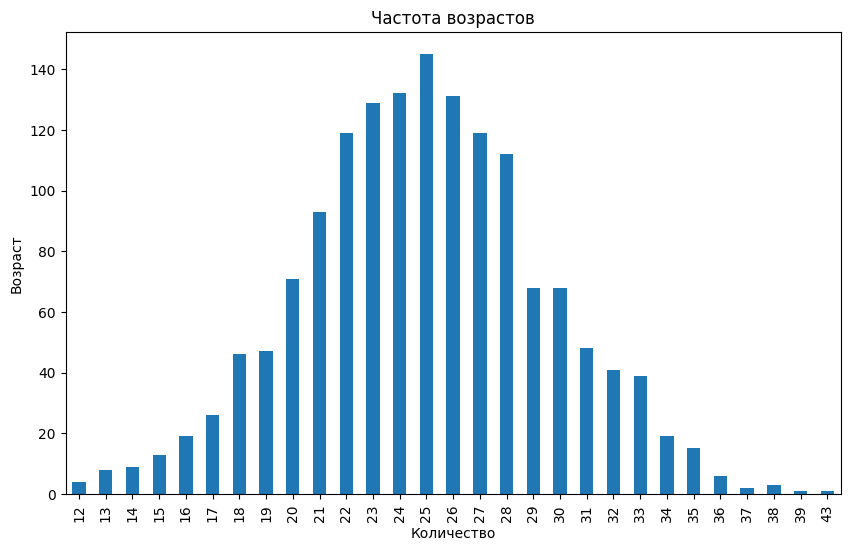

In [46]:
plt.figure(figsize=(10, 6))
users['age'].value_counts().sort_index().plot(kind='bar')
plt.title('Частота возрастов')
plt.xlabel('Количество')
plt.ylabel('Возраст')
plt.show()

Хех, идеальная картина. Наиболее вероятный возраст 25 лет.

Выведем статистику по этому столбцу:

In [47]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Средний возраст - 24,9 лет, стандартное отклонение - 4,57, т.е. вероятность того, что возраст пользователя находится в промежутке от 20 до 30 лет составляет не менее 68%. Минимальный возраст 12, максимальный 43. Мода (из графика) и медиана - 25 лет.

Задача - посчитать расстояние, которое пользователь преодолел за одну поездку. Выведем гистограмму для столбца distance:

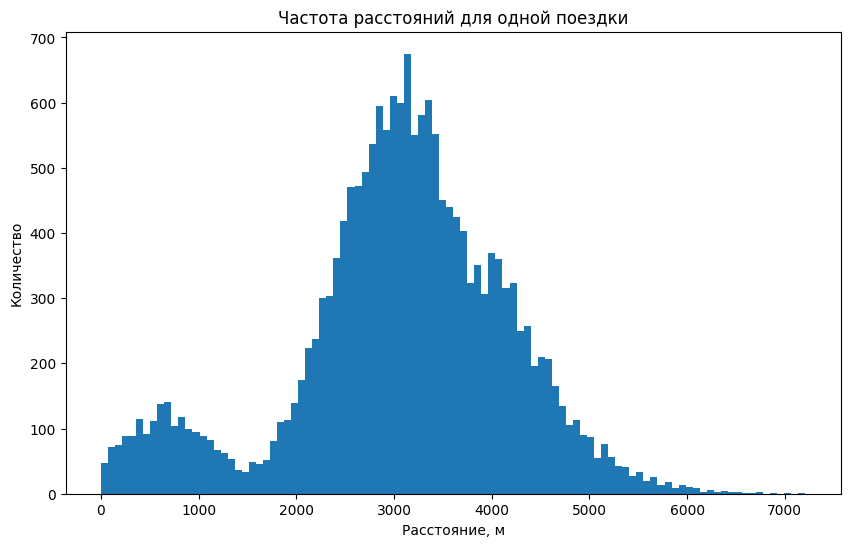

In [48]:
plt.figure(figsize=(10, 6))
df['distance'].plot(kind='hist', bins=100)
plt.title('Частота расстояний для одной поездки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество')
plt.show()

In [49]:
df['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Получили, что в среднем пользователи проезжали чуть более 3070 метров, максимум - 7,21 километров, медианное значение - 3133 метра. 

Если усреднить по всем пользователям:

In [50]:
df.groupby('user_id')['distance'].mean().round().mean()

3077.2992177314213

Средняя продолжительность поездки:

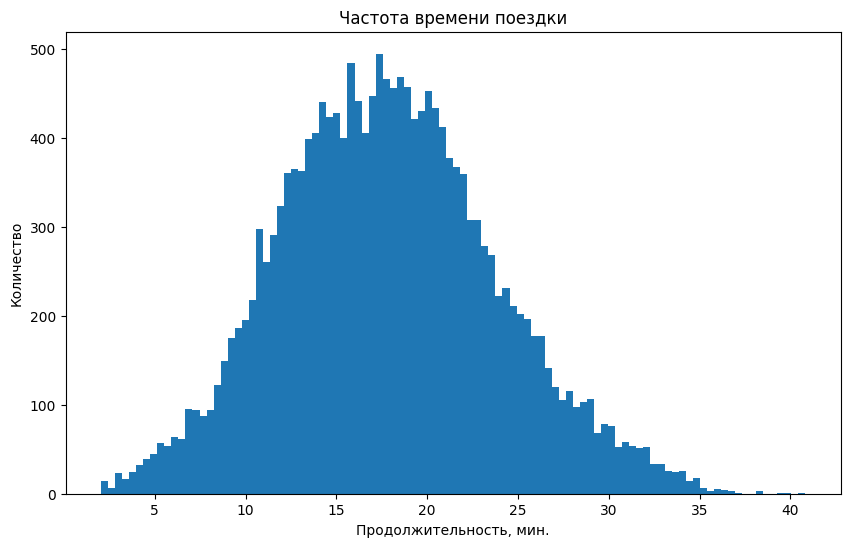

In [51]:
plt.figure(figsize=(10, 6))
df['duration'].plot(kind='hist', bins=100)
plt.title('Частота времени поездки')
plt.xlabel('Продолжительность, мин.')
plt.ylabel('Количество')
plt.show()

In [52]:
df['duration'].describe()

count    18068.000000
mean        17.883036
std          5.964263
min          2.035632
25%         13.672510
50%         17.693472
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее время поездки составляет 17,88 минут, максимальное 41 минуту. Медиана равна 17,69 минут.

Также, располагая столбцом gender, мы можем посмотреть соотношение полов:

In [53]:
users['gender'].value_counts()

Мужской    946
Женский    588
Name: gender, dtype: int64

В процентах графически:

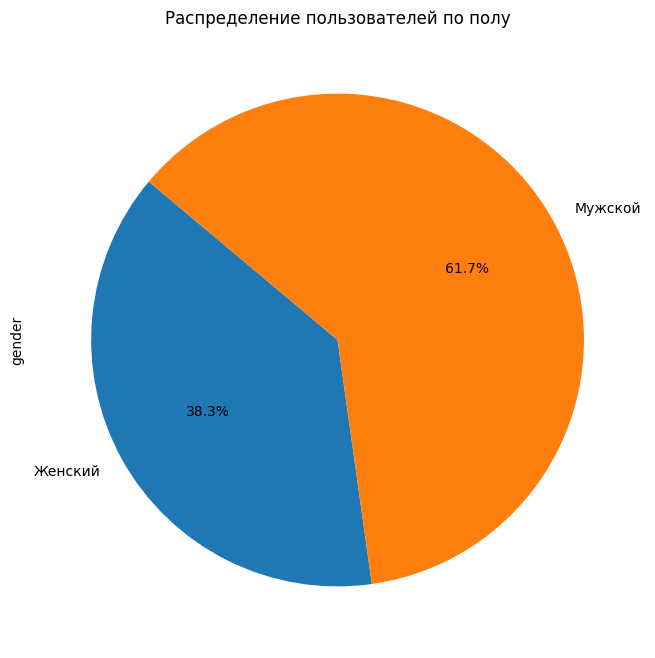

In [54]:
labels = ['Женский', 'Мужской']

plt.figure(figsize=(8, 8))
users['gender'].value_counts(ascending=True).plot(kind='pie', labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Распределение пользователей по полу')
plt.show()

Мы видим, что мужчины используют сервис гораздо чаще, чем женщины.

### Объединение данных

Выше, во время предобработки данных мы уже объединили датафреймы в один df. Также, уже были созданы отдельные датафреймы по типу подписки - df_free и df_ultra.

Визуализируем для них информацию о расстоянии и времени поездок:

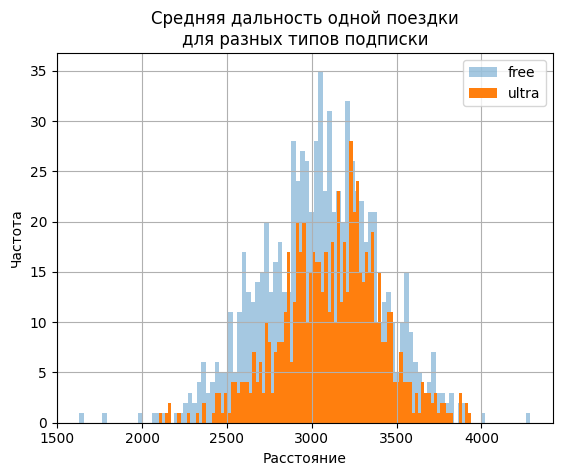

In [55]:
# Построение первой гистограммы для df_free
df_free.groupby('user_id')['distance'].mean().round().hist(bins=100, alpha=0.4, label='free')

# Построение второй гистограммы для df_ultra
df_ultra.groupby('user_id')['distance'].mean().round().hist(bins=100, alpha=1, label='ultra')

plt.title('Средняя дальность одной поездки\nдля разных типов подписки')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.legend()
plt.show()

Мы видим, что платные подписчики в среднем за одну поездку преодолевают чуть большее расстояние.

Что касается продолжительности одной поездки:

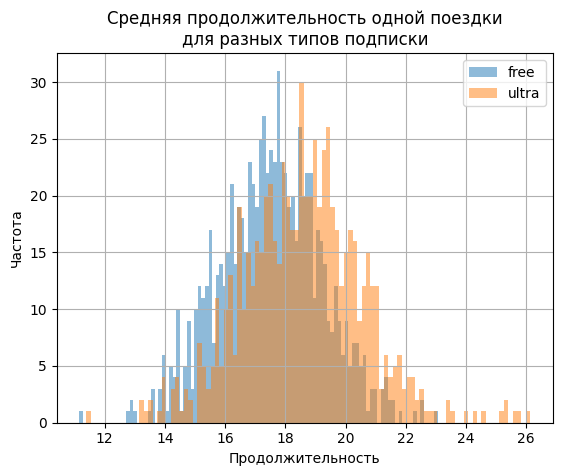

In [56]:
# Построение первой гистограммы для df_free
df_free.groupby('user_id')['duration'].mean().hist(bins=100, alpha=0.5, label='free')

# Построение второй гистограммы для df_ultra
df_ultra.groupby('user_id')['duration'].mean().hist(bins=100, alpha=0.5, label='ultra')

plt.title('Средняя продолжительность одной поездки\nдля разных типов подписки')
plt.xlabel('Продолжительность')
plt.ylabel('Частота')
plt.legend()
plt.show()

Здесь мы видим, что платным подписчикам требуется в среднем больше времени для одной поездки, чем бесплатным. И в этом есть логика - минута стоит дешевле, куда торопиться, ну и среднее расстояние у них чуть больше.

### Подсчёт выручки

Сделаем копию датафрейма:

In [57]:
df_copy = df.copy()

И на ее основе создадим датафрейм с агрегированными данными:

In [58]:
# Округляем значения в столбце 'duration' в большую сторону
df_copy['duration'] = np.ceil(df_copy['duration'])

# Агрегируем данные по user_id и month
aggregated_df = df_copy.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    total_rides=('distance', 'count'),
    total_duration=('duration', 'sum')
).reset_index()

# Добавляем столбец с выручкой
aggregated_df['revenue'] = (
    aggregated_df['total_rides'] * df_copy.groupby(['user_id', 'month'])['start_ride_price'].first().values +
    aggregated_df['total_duration'] * df_copy.groupby(['user_id', 'month'])['minute_price'].first().values +
    df_copy.groupby(['user_id', 'month'])['subscription_fee'].first().values
)

aggregated_df.head()

,user_id,month,total_distance,total_rides,total_duration,revenue
0,1,1,7027.511294,2,42.0,451.0
1,1,4,754.159807,1,7.0,241.0
2,1,8,6723.470560,2,46.0,475.0
3,1,10,5809.911100,2,32.0,391.0
4,1,11,7003.499363,3,56.0,535.0


Выведем сводку статистических данных для полученной таблицы:

In [59]:
aggregated_df.describe()

,user_id,month,total_distance,total_rides,total_duration,revenue
count,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000
mean,811.061160,6.477539,4896.362584,1.594564,29.310652,343.299709
std,440.350798,3.443928,2911.516556,0.831604,16.757279,153.916982
min,1.000000,1.000000,2.570787,1.000000,3.000000,74.000000
25%,435.000000,4.000000,2972.202146,1.000000,17.000000,234.000000
50%,843.000000,6.000000,3988.723985,1.000000,24.000000,319.000000
75%,1191.000000,9.000000,6421.375890,2.000000,38.000000,420.000000
max,1534.000000,12.000000,23429.487786,7.000000,143.000000,1444.000000


Мы видим, что пользователи совершали до 7 поездок в месяц и могли проехать за месяц до 23,5 км. Общее время поездок в месяц для одного пользователя не превышало 2 часа 23 минуты, а помесячная выручка была не более 1444 рублей с пользователя.

### Проверка гипотез

#### Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки

Сколько времени в среднем тратят пользователи с подпиской и без на одну поездку?

Здесь мы считаем, что две генеральных совокупности, из которых взяты наши выборки, не зависят друг от друга. Также, поскольку выборки не равны по размеру между собой, мы считаем дисперсии наших совокупностей разными и указываем соответствующий параметр, чтобы тест посчитал дисперсии выборок по отдельности.

**Нулевая гипотеза:** средние значения затрат времени на одну поездку для пользователей из двух групп равны.

**Альтернативная гипотеза:** среднее значение затрат времени пользователей с подпиской больше, чем среднее значение затрат времени пользователей без подписки.

In [60]:
# задаём уровень значимости
alpha = 0.05

# траты первой группы пользователей (с подпиской)
first_group_total = df_ultra.groupby('user_id')['duration'].mean()

# траты второй группы пользователей (без подписки)
second_group_total = df_free.groupby('user_id')['duration'].mean()

# проводим t-тест для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group_total, second_group_total, alternative='greater', equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.3008904869368011e-27
Отвергаем нулевую гипотезу


Полученное значение p-value гораздо меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу в пользу альтернативной. А нам это и нужно.

Посчитаем "по-старинке" средние значения для двух групп пользователей:

In [61]:
# Без подписки
df_free.groupby('user_id')['duration'].mean().mean()

17.507745212505345

In [62]:
# Без подписки
df_ultra.groupby('user_id')['duration'].mean().mean()

18.574379961859677

Да, мы видим, что пользователи с подпиской тратят на одну поездку в среднем на одну минуту больше, чем пользователи без подписки. Но есть нюанс... Давайте посчитаем среднее число поездок для таких пользователей:

In [63]:
# Без подписки
df_free.groupby('user_id')['duration'].count().mean()

13.853892215568862

In [64]:
# С подпиской
df_ultra.groupby('user_id')['duration'].count().mean()

9.298998569384835

Пользователи без подписки пользуются сервисом почти в 1,5 раза чаще своих визави. Суммарное время для одного пользователя

In [65]:
# Без подписки
17.51 * 13.85

242.51350000000002

In [66]:
# С подпиской
18.57 * 9.3

172.70100000000002

Т.е. платный подписчик за год потратил меньше 3-х часов, а бесплатный - 4 часа. Но, раз в гипотезе речь шла об одной поездке, то считаем ее верной.

<span style="color: green; font-size: 48px;">✔</span>

#### Гипотеза 2. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Теперь посчитаем среднее расстояние на одну поездку:

In [67]:
# Без подписки
df_free.groupby('user_id')['distance'].mean().mean()

3047.0234410892217

In [68]:
# С подпиской
df_ultra.groupby('user_id')['distance'].mean().mean()

3113.459926039899

Пусть нулевая гипотеза заключается в том, что среднее расстояние равно 3130 метрам или меньше. Тогда альтернативная гипотеза - среднее расстояние превышает 3130 метров:

In [69]:
revenue = df_ultra.groupby('user_id')['distance'].mean()

interested_value = 3130 # расстояние одной поездки

alpha = 0.05 # укажите уровень статистической значимости

results = st.ttest_1samp(
                    revenue,
                    interested_value,
                    alternative='greater') # используйте метод st.ttest_1samp

print('p-значение:', results.pvalue) # добавьте в аргумент p-value

if (results.pvalue < alpha): # сравните полученный p-value и уровень значимости):
    print('Отвергаем нулевую гипотезу: среднее расстояние значимо выше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров')

p-значение: 0.9275041260050892
Не получилось отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров


In [70]:
revenue = df_free.groupby('user_id')['distance'].mean()

interested_value = 3130 # расстояние одной поездки

alpha = 0.05 # укажите уровень статистической значимости

results = st.ttest_1samp(
                    revenue,
                    interested_value,
                    alternative='greater') # используйте метод st.ttest_1samp

print('p-значение:', results.pvalue) # добавьте в аргумент p-value

if (results.pvalue < alpha): # сравните полученный p-value и уровень значимости):
    print('Отвергаем нулевую гипотезу: среднее расстояние значимо выше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров')

p-значение: 0.9999999999954513
Не получилось отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров


Да, и те и другие укладываются в оптимальное расстояние 3130 метров.

<span style="color: green; font-size: 48px;">✔</span>

#### Гипотеза 3. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

Что касается помесячной выручки, мы ее можем посчитать из датафрейма с агрегированными данными aggregate_df. Правда, в нем нет прямого указания на тип подписки. Информацию о подписке можно получить через номер id пользователя. Ранее мы выяснили, что номера с 1 по 699 соответствуют платной подписке, а с 700 и выше (всего 835 пользователей) - бесплатной. Разница в 1.1946 раз. Чтобы сравнивать суммарную выручку, нужно уровнять число подписчиков:

In [71]:
aggregated_df = pd.merge(aggregated_df, users[['user_id', 'subscription_type']], how='left', on='user_id')

Проверим гипотезу о том, что пользователи с подпиской приносят за месяц больше выручки, чем пользователи без подписки?

**Нулевая гипотеза:** помесячная выручка для пользователей из двух групп равна.

**Альтернативная гипотеза:** выручка за месяц для пользователей с подпиской больше, чем аналогичная выручка для пользователей без подписки.

In [72]:
# задаём уровень значимости
alpha = 0.05

# траты первой группы пользователей (с подпиской)
revenue_ultra = aggregated_df.query('subscription_type=="ultra"')['revenue']

# траты второй группы пользователей (без подписки)
revenue_free = aggregated_df.query('subscription_type=="free"')['revenue']

# проводим t-тест для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(revenue_ultra, revenue_free, alternative='greater', equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 3.5711469222437345e-36
Отвергаем нулевую гипотезу


Полученное значение p-value гораздо меньше заданного уровня значимости, альтернативная гипотеза подтвердилась - средний пользователь с подпиской приносит бОльшую выручку, чем пользователь без подписки.

<span style="color: green; font-size: 48px;">✔</span>

#### Гипотеза 4.  Количество обращений в техподдержку значимо снизилось после обновления серверов, с которыми взаимодействует мобильное приложение

Здесь речь идет о двух зависимых выборках и нам необходимо проверить гипотезу о равенстве среднего значения генеральной совокупности до и после изменения. Это можно сделать с помощью **двухвыборочного t-теста для зависимых выборок**, используя метод **scipy.stats.ttest_rel**, аргументами которого будут наборы данных о количестве обращений до обновления и после. А указав аргумент **alternative='greater'**, будет проверена правосторонняя альтернативная гипотеза о том, что истинное среднее генеральной совокупности до изменения больше, чем после изменения.

### Распределения

#### Акция по раздаче промокодов на один месяц бесплатной подписки.

Используем биномиальное распределение для подбора числа промокодов, которые необходимо раздать, чтобы вероятность, что 100 существующих клиентов не продлят подписку, была примерно 5%:

In [73]:
p = 0.1  # вероятность продления подписки
n_target = 100  # целевое количество продлений подписки
alpha = 0.05  # вероятность не выполнить план

# Функция подбора минимального количества промокодов
def find_min_n(n_target, p, alpha):
    n = n_target + 700  # начнем с 800 испытаний
    while binom.cdf(n_target - 1, n, p) > alpha: # невыполнение цели начинается с 99, поэтому n_target - 1
        n += 1
    return n

In [74]:
# Найдем минимальное количество промокодов
min_n = find_min_n(n_target, p, alpha)
min_n

1161

Мы получили значение 1161 для минимального числа промокодов.

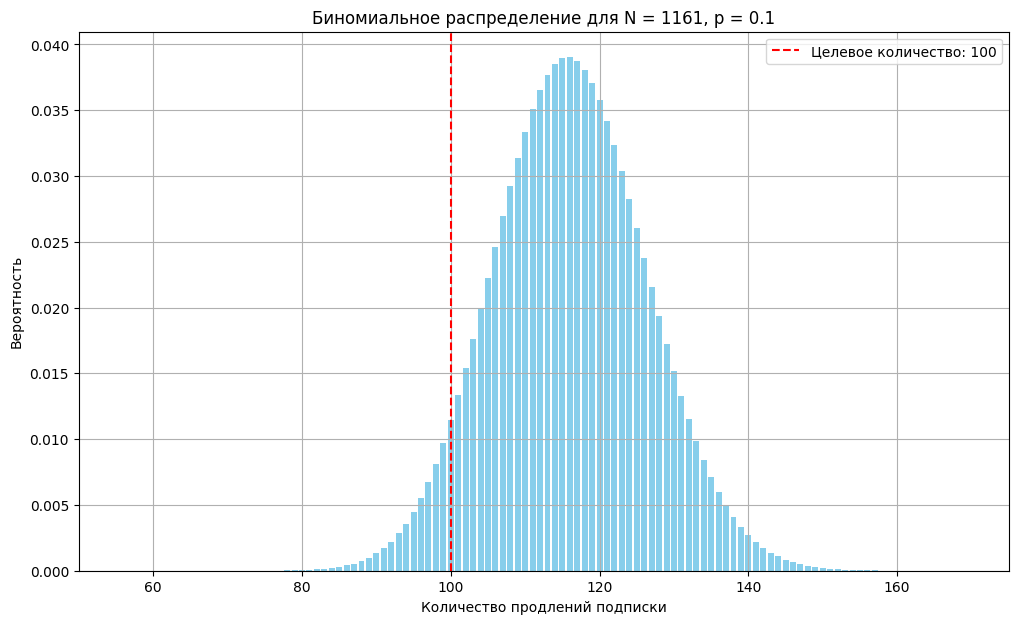

In [75]:
# Построим график биномиального распределения для min_n
x = np.arange(0, min_n + 1)
pmf_values = binom.pmf(x, min_n, p)

# Построение графика
plt.figure(figsize=(12, 7))
plt.bar(x, pmf_values, color='skyblue')
# Ограничение по х
plt.xlim(50, 175)

plt.axvline(n_target, color='red', linestyle='--', label=f'Целевое количество: {n_target}')
plt.title(f'Биномиальное распределение для N = {min_n}, p = {p}')
plt.xlabel('Количество продлений подписки')
plt.ylabel('Вероятность')
plt.legend()
plt.grid(True)
plt.show()

#### Открытие разосланных клиентам push-уведомлений

Найдем вероятность того, что push-уведомление откроют не более 399,5 тысяч пользователей. Построим график плотности вероятности для биномиального распределения и его нормальную аппроксимацию:

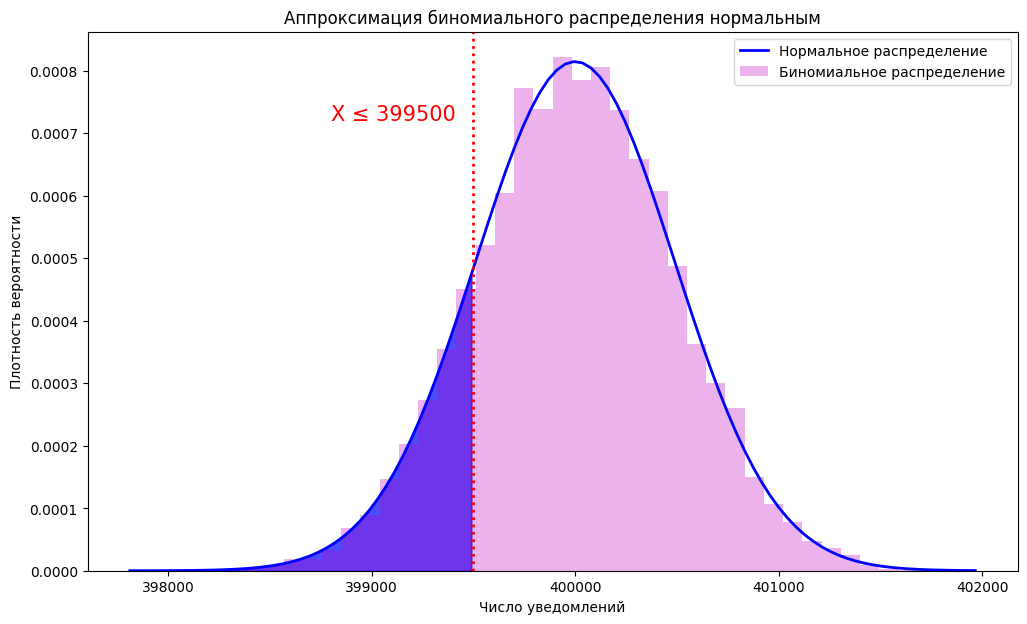

In [76]:
# Параметры распределения
n = 1000000  # количество испытаний
p = 0.4      # вероятность успеха

# Генерация случайных величин с биномиальным распределением
binom_data = np.random.binomial(n, p, size=10000)

# Нормальное распределение
mu = n * p  # математическое ожидание
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение

# Построение графика
plt.figure(figsize=(12,7))

# Гистограмма биномиального распределения
plt.hist(binom_data, bins=40, density=True, alpha=0.3, color='m', label='Биномиальное распределение')

# Плотность нормального распределения
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu, sigma)
plt.plot(x, p, 'b', linewidth=2, label='Нормальное распределение')


# Вертикальная линия для значения 399500
value_to_check = 399500
plt.axvline(value_to_check, color='r', linestyle='dotted', linewidth=2)

# Закраска области левее вертикальной линии
plt.fill_between(x, p, where=(x <= value_to_check), color='blue', alpha=0.7)

# Подпись линии
plt.text(value_to_check + -700, 0.00072, f'X ≤ 399500', color='r', size=15)

# Настройки графика
plt.title('Аппроксимация биномиального распределения нормальным')
plt.xlabel('Число уведомлений')
plt.ylabel('Плотность вероятности')
plt.legend()

plt.show()

Чтобы получить требуемую вероятность, нужно посчитать выделенную синим площадь под графиком.

Изменим графическое представление, чтобы наглядно увидеть искомую вероятность:

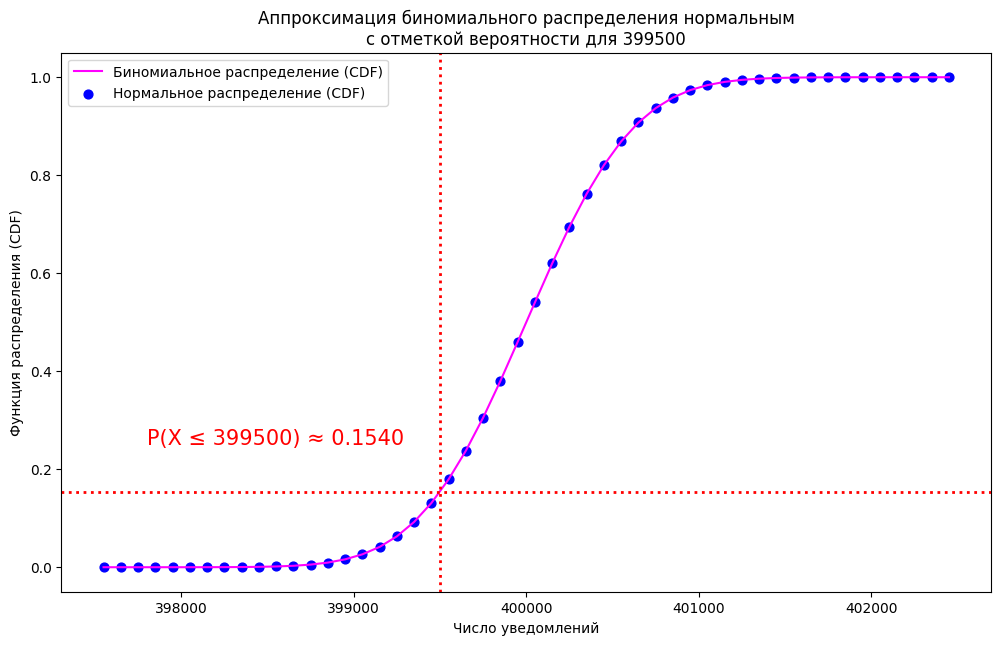

In [77]:
# Параметры распределения
n = 1000000  # количество испытаний
p = 0.4      # вероятность успеха

# Параметры нормального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Значения для оси X с уменьшенным количеством точек
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 50)

# Вычисление CDF для биномиального и нормального распределений
binom_cdf = binom.cdf(x, n, p)
norm_cdf = norm.cdf(x, mu, sigma)

# Вероятность того, что значение не достигнет 399500
value_to_check = 399500
binom_prob = binom.cdf(value_to_check, n, p)
norm_prob = norm.cdf(value_to_check, mu, sigma)

# Построение графика
plt.figure(figsize=(12,7))

# График CDF нормального распределения с точками
plt.scatter(x, norm_cdf, color='blue', label='Нормальное распределение (CDF)', s=40)

# График CDF биномиального распределения
plt.plot(x, binom_cdf, color='magenta', label='Биномиальное распределение (CDF)')

# Вертикальная линия для значения 399500
plt.axvline(value_to_check, color='r', linestyle='dotted', linewidth=2)

plt.axhline(binom_prob, color='r', linestyle='dotted', linewidth=2)

# Настройки графика
plt.title('Аппроксимация биномиального распределения нормальным\nс отметкой вероятности для 399500')
plt.xlabel('Число уведомлений')
plt.ylabel('Функция распределения (CDF)')
plt.legend()

# Подпись вероятности
plt.text(value_to_check + -1700, 0.25, f'P(X ≤ 399500) ≈ {binom_prob:.4f}', color='r', size=15)

# Отображение графика
plt.show()


Мы получили вероятность 15.4%, что push-уведомление откроют не более 399,5 тысяч пользователей.

### Выводы

* были обнаружены и удалены дубликаты строк датафрейма users;
* на основе столбца с именами создан новый столбец, в котором определен пол пользователя;
* проверка датафрейма rides на аномалии помогла найти соответствие между идентификатором пользователя и типом подписки: 1-699 - подписка Ultra, 700-1534 - бесплатная подписка;
* аномальные значение в столбце duration заменены на усредненный вариант продолжительности поездки, исходя из средней скорости движения пользователей;
* обнаружение независимости данных от сезонного фактора;
* определение минимальной - 10км/ч и максимальной - 30км/ч скорости движения по графику зависимости расстояния от времени;
* выявление привязки длительности коротких (до 130м) поездок к целому числу минут;
* из 8 городов Пятигорск лидирует по числу пользователей сервиса - 219 человек;
* платные подписчики составляют 45,6% всех пользователей, бесплатные - 54,4%;
* средний возраст пользователя - 25 лет;
* за одну поездку преодолевается в среднем 3077 метров;
* наиболее вероятная средняя продолжительность поездки - 18 минут;
* из общего числа пользователей, мужчины составляют 61,7%, женщины - 38,3%;
* платные подписчики в среднем за одну поездку преодолевают чуть большее расстояние, на что им требуется больше времени, чем бесплатным подписчикам;
* если просуммировать данные по отдельным пользователям за месяц, то можно увидеть, что пользователи совершали до 7 поездок и могли проехать до 23,5 км, потратить на поездки до 2 часов 23 минут и до 1444 рублей;
* подтвердилась гипотеза №1 о том, что пользователи с подпиской тратят больше времени на поездки;
* подтвердилась гипотеза №2 о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
* подтвердилась гипотеза №3 о том, что помесячная выручка от пользователя с подпиской выше, чем выручка от пользователя без подписки;
* было определено минимальное количество промокодов, которое необходимо разослать, чтобы вероятность не выполнить план по продлению сотней пользователей подписки равнялась примерно 5%. Разослать нужно не менее 1161 промокода;
* вероятность, что из 1 млн. разосланных push-уведомлений, их откроют менее 399,5 тысяч пользователей составляет 15,4%.

**Послесловие**

Я постарался отнестись к предоставленным данным, как к реальным. И, в таком ключе и выполнил проект. Но, практически с самого начала, стало понятно, что данные плохо соответствуют настоящему положению дел.

В реальности, на рынке кикшеринга  в 2021 году доминировали (80%) Whoosh и URent. Абонементы от этих сервисов стали возможны только в мае и июне соответственно. В июле добавился сервис от Яндекса. О том, что кикшеринг не работает круглый год, я уже упоминал в проекте.  Число платных подписчиков составляет примерно 30%, при этом они совершают 50% всех поездок. Мужчины составляют примерно 80% всех подписчиков.

В общем, все это лишний раз подтверждает, что наши данные были искусственно созданы, из-за чего ряд вопросов остались без ответа. Трудно найти логику в какой-то искусственной аномалии, когда ее там изначально не было.